# Classical linear piecewise function


Here, we are going to take a break from the quantum computing, and look at implementing a linear piecewise approximation to evaluate a function. We will take particular considerations to control and minimize the number of bits required to perform this action.

We look to approximate the function $f(x)$ given $x$ with a linear function within $2^m$ domains such that $f(x)\approx A_1^lx + A_0^l$ for $x$ within domain $l$.

In [1]:
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

First, let's define what function we wish to evaluate:

In [3]:
def f_x(x):
    return np.arctan(x)

Now let us define a bit string to store the $x$ values:

In [4]:
phase = True
nx = 5
nintx = 3
npresx = nx - nintx
if phase:
    npresx -= 1

This $x$ register naturally has a minimum and maximum value that we can take and define the range of possible values with the given precision:

In [5]:
xmin = -2.**(nintx)
xmax = 2.**(nintx) - 2.**(-npresx)

xs = np.linspace(xmin,xmax,2**nx)

print(xmin, xmax)

-8.0 7.5


We can see the range of values have the correct number of precision bits:

In [6]:
print(npresx,qt.get_npres(xs))

1 1


Now let's define the boundaries of the piecewise function that we wish to evaluate. Let us consider $2^m$ boundaries:

In [7]:
m = 3
bounds = np.linspace(xmin, xmax, (2**m))

We can use some functions in `qiskit_tools` that uses the Remez algorithm to determine coefficients of the linear functions that minimize the error $f(x) - A_1^lx - A_0^l$ across the whole of domain $l$ using `get_bound_coeffs`, and we can evaluate the piecewise function using `piecewise_poly`:

In [8]:
norder = 1
coeffs = qt.get_bound_coeffs(f_x, bounds, norder, reterr=False).T
ys = qt.piecewise_poly(xs, coeffs.T, bounds)

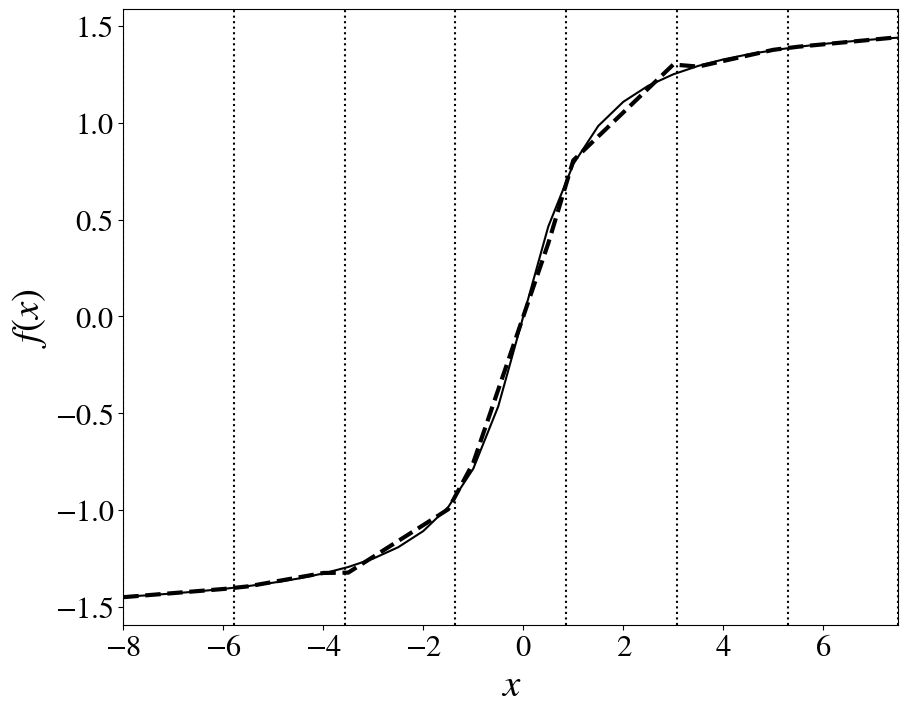

In [9]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

for bound in bounds:
    ax.axvline(bound, ls=':', color='black')

ax.plot(xs, f_x(xs), color='black');
ax.plot(xs, ys, color='black', ls='--', lw=3);
ax.set_xlabel(r'$x$', fontsize=fontsize);
ax.set_ylabel(r'$f(x)$', fontsize=fontsize);
ax.set_xlim(xmin,xmax);
ax.tick_params(axis='both', labelsize=ticksize);

This looks very nice! We are able to evaluate the function well with the linear piecewise approximation it seems. Now lets see how many bits this requires to perform:

In [10]:
# The number of integer bits of A1, A0 and the result
nint0 = qt.get_nint(coeffs[0])
nint1 = qt.get_nint(coeffs[1])
nint = nintx + nint0

# The number of precision bits of A1, A0 and the result
npres0 = qt.get_npres(coeffs[0])
npres1 = qt.get_npres(coeffs[1])
npres = npresx + npres0

# The total number of bits of A1, A0 and the result
n0 = npres0 + nint0 + 1
n1 = npres1 + nint1 + 1
n = npres + nint + 1

In [11]:
print('A0 bits:', n0)
print('A1 bits:', n1)
print('Result bits:', n)

A0 bits: 56
A1 bits: 55
Result bits: 60


Uh oh! This seems like quite a large number of bits. If we wish to limit the number of bits used, then we need to make some extra considerations.

First, let's simply round the digits to a select number of significant figures using `round_sig`:

In [12]:
nsig0, nsig1 = 5, 5
coeffs[0] = qt.round_sig(coeffs[0], nsig0)
coeffs[1] = qt.round_sig(coeffs[1], nsig1)

In [13]:
# The number of integer bits of A1, A0 and the result
nint0 = qt.get_nint(coeffs[0])
nint1 = qt.get_nint(coeffs[1])
nint = nintx + nint0

# The number of precision bits of A1, A0 and the result
npres0 = qt.get_npres(coeffs[0])
npres1 = qt.get_npres(coeffs[1])
npres = npresx + npres0

# The total number of bits of A1, A0 and the result
n0 = npres0 + nint0 + 1
n1 = npres1 + nint1 + 1
n = npres + nint + 1

In [14]:
print('A0 bits:', n0)
print('A1 bits:', n1)
print('Result bits:', n)

A0 bits: 54
A1 bits: 71
Result bits: 58


When we recount the number of bits, we see it actually can make the problem worse! We need to instead specify and limit the number of precision bits that we store the values of $A_0^l$ and $A_1^l$.

In [15]:
npres0, npres1 = 4, 4

n0 = npres0 + nint0 + 1
n1 = npres1 + nint1 + 1

We can now convert the values onto a binary string of length limited to the given number of precision bits:

In [16]:
rcoeffs = []
for coeff in coeffs[0]:
    # Convert coefficient to binary string of new length n0, then calculate the corresponding decimal value
    rcoeff = qt.bin_to_dec(qt.my_binary_repr(coeff, n0, nint=nint0, phase=phase), nint=nint0, phase=phase)
    rcoeffs.append(rcoeff)
    
coeffs[0] = np.array(rcoeffs)

Now that we have new values for the gradients with now limited precision, we need to recalculate the bias term $A_0^{l}$ to minimize the difference between the linear function and the target function:

In [17]:
# Calculate the differences between the f(x) and A1x over all x
fdifs = f_x(xs) - qt.piecewise_poly(xs, np.array([coeffs[0],np.zeros(len(coeffs[1]))]).T, bounds)
coeffs_ = []
bounds__ = bounds
bounds__[-1] = np.inf
for i in np.arange(len(bounds__))[:-1]:
    # Calculate the mean differences in each domain to be the new bias A0
    coeffs_.append(np.mean(fdifs[np.greater_equal(xs,bounds__[i])&np.greater(bounds__[i+1],xs)]))

coeffs[1] = np.array(coeffs_)    

Just incase, let's recalculate the number of integer bits now that we have new values of $A_0^l$:

In [18]:
nint1 = qt.get_nint(coeffs[1])

print(nint1)

1


Similarly as we did for $A_1^l$, lets force the values of $A_0^l$ onto the bit string with the given precision:

In [19]:
rcoeffs = []
for coeff in coeffs[1]:
    # Convert coefficient to binary string of new length n1, then calculate the corresponding decimal value
    rcoeff = qt.bin_to_dec(qt.my_binary_repr(coeff, n1, nint=nint1, phase=phase), nint=nint1, phase=phase)
    rcoeffs.append(rcoeff)

coeffs[1] = np.array(rcoeffs)

Now let us recalculate the number of required bits:

In [20]:
# The number of integer bits of A1, A0 and the result
nint0 = qt.get_nint(coeffs[0])
nint1 = qt.get_nint(coeffs[1])
nint = nintx + nint0

# The number of precision bits of the result
npres = npresx + npres0

# The total number of bits of A1, A0 and the result
n0 = npres0 + nint0 + 1
n1 = npres1 + nint1 + 1
n = npres + nint + 1

In [21]:
print('A0 bits:', n0)
print('A1 bits:', n1)
print('Result bits:', n)

A0 bits: 6
A1 bits: 6
Result bits: 10


This is better! We can now evaluate the linear piecewise approximation across the domain and plot it as before:

In [22]:
ys_rnd = qt.piecewise_poly(xs, coeffs.T, bounds)

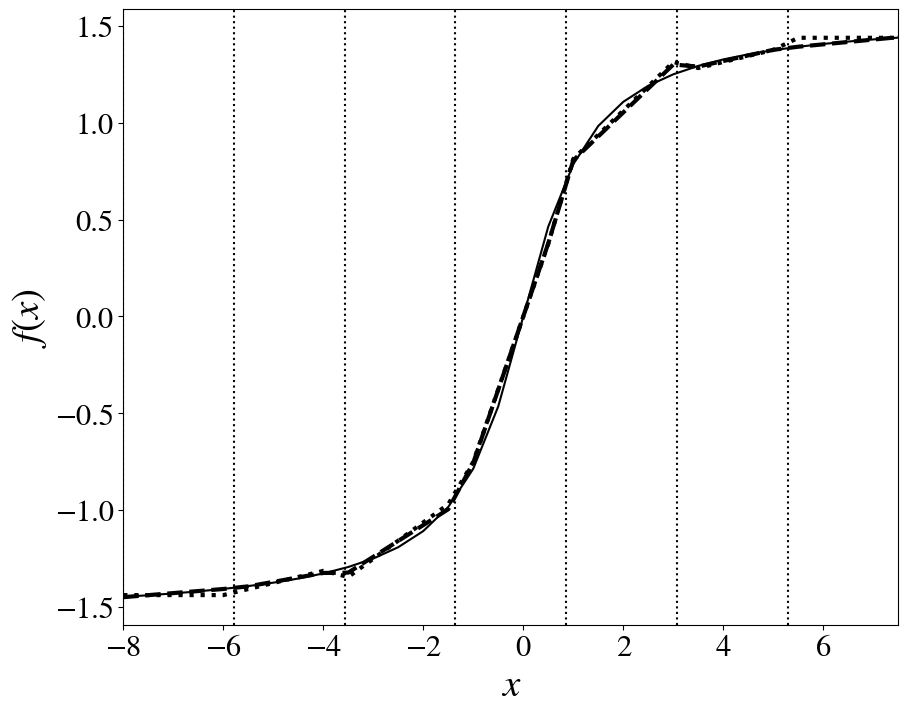

In [23]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

for bound in bounds:
    ax.axvline(bound, ls=':', color='black')
    
ax.plot(xs, f_x(xs), color='black');
ax.plot(xs, ys, color='black', ls='--', lw=3);
ax.plot(xs, ys_rnd, color='black', ls=':', lw=3);
ax.set_xlabel(r'$x$', fontsize=fontsize);
ax.set_ylabel(r'$f(x)$', fontsize=fontsize);
ax.set_xlim(xmin,xmax);
ax.tick_params(axis='both', labelsize=ticksize);

Looks good! The limiting of the precision results in larger errors as we would expect, but now we have control of the dials that dictates this. 

We may also be interested in limiting the number of bits to store the result in, with the assumption that the same bit string holds both the values $A_1^l x$ and $A_1^l x + A_0^l$ (this will become relevant later when we move this onto the quantum computer).

Let us first calculate what these values are:

In [24]:
A1x = qt.piecewise_poly(xs, np.array([coeffs[0],np.zeros(len(coeffs[1]))]).T, bounds)

We can use our `get_nint` tools to then find the minimum number of bits for this bit string:

In [25]:
nint = qt.get_nint([A1x, ys_rnd])
n = npres + nint + 1

In [26]:
print(nint, npres, n)

1 5 7


We can now wrap all of this up into one function called `optimize_coeffs_qubits`:

In [27]:
n, n0, nint, nintcs, coeffs, bounds = qt.optimize_coeffs_qubits(f_x, xs, m, npres0, npres1, norder=norder, phase=phase)

That's better :)